In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/embeddings/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-acm')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-acm/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/embeddings/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = ['year'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True)

W0908 10:02:26.424383  2508 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0908 10:02:26.865839  2508 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0908 10:02:57.860320  2508 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0908 10:02:57.866304  2508 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0908 10:02:57.866304  2508 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backen

Number of inputs to dense layer: 14


# Train model 

In [4]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, batch_size=16384,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

W0908 10:04:45.201108  2508 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0908 10:04:45.257589  2508 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 179699 samples, validate on 22463 samples
Epoch 1/20
179699/179699 [==============================] - 21s 117us/step - loss: 0.6293 - acc: 0.9900 - val_loss: 0.5747 - val_acc: 0.9905
Epoch 2/20
179699/179699 [==============================] - 19s 105us/step - loss: 0.5292 - acc: 0.9900 - val_loss: 0.4749 - val_acc: 0.9905
Epoch 3/20
179699/179699 [==============================] - 19s 108us/step - loss: 0.4289 - acc: 0.9900 - val_loss: 0.3709 - val_acc: 0.9905
Epoch 4/20
179699/179699 [==============================] - 19s 108us/step - loss: 0.3207 - acc: 0.9900 - val_loss: 0.2573 - val_acc: 0.9905
Epoch 5/20
179699/179699 [==============================] - 19s 107us/step - loss: 0.2097 - acc: 0.9900 - val_loss: 0.1563 - val_acc: 0.9905
Epoch 6/20
179699/179699 [==============================] - 19s 105us/step - loss: 0.1279 - acc: 0.9900 - val_loss: 0.0980 - val_acc: 0.9905
Epoch 7/20
179699/179699 [==============================] - 19s 106us/step - loss: 0.0861 - acc: 0.9900

# Learning curves

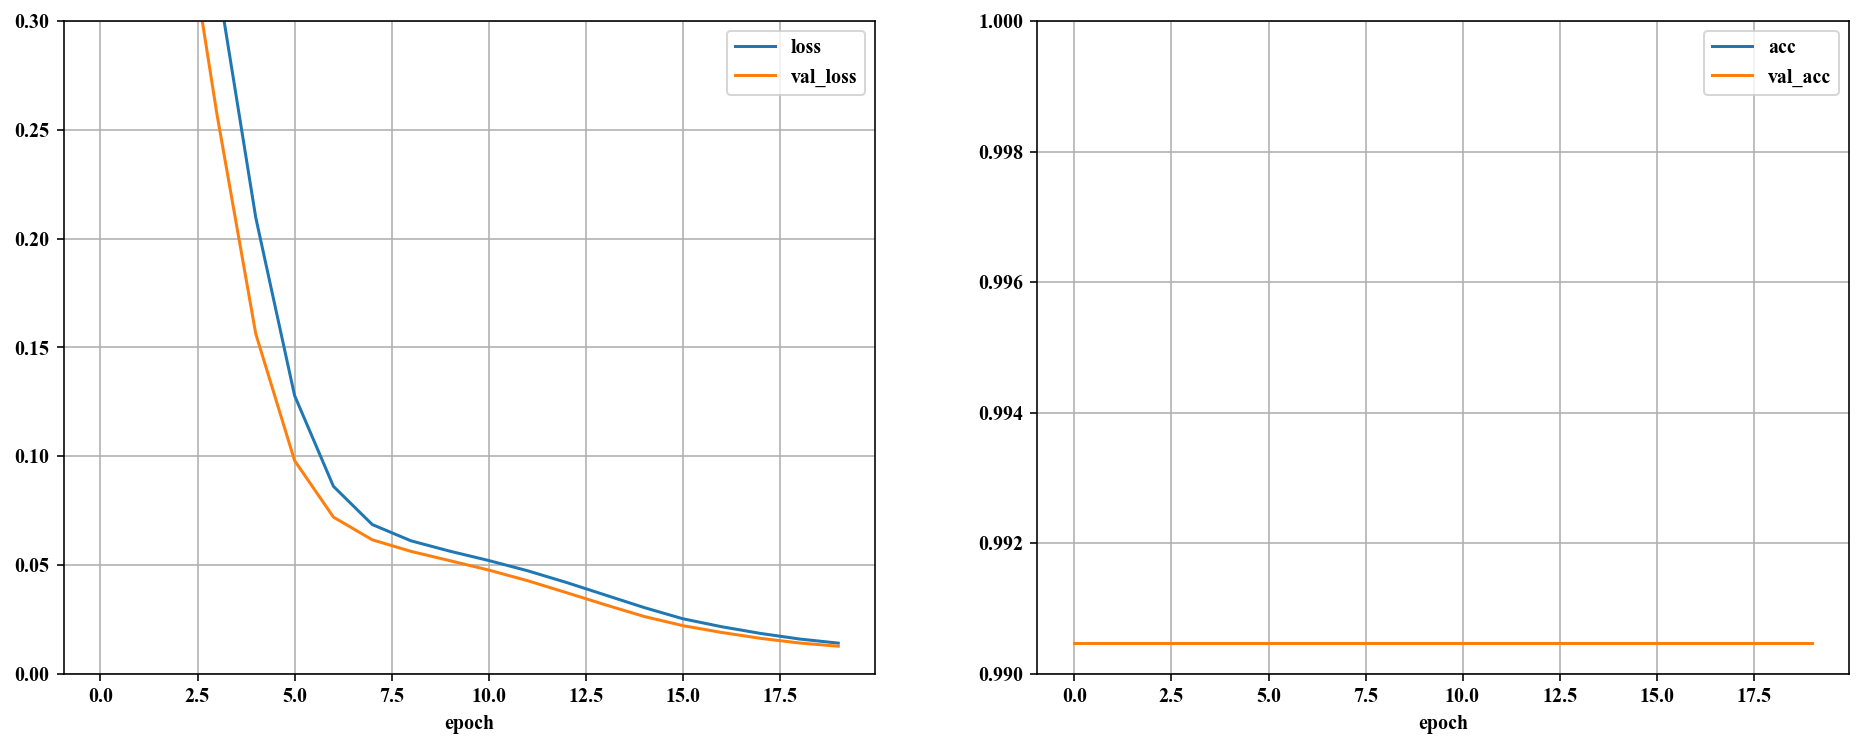

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.3)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(.99, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [6]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     22249
           1       0.00      0.00      0.00       214

   micro avg       0.99      0.99      0.99     22463
   macro avg       0.50      0.50      0.50     22463
weighted avg       0.98      0.99      0.99     22463

[[22249     0]
 [  214     0]]


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [7]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,title,authors,venue,year,id2,title,authors,venue,year
20581,conf/sigmod/RaoR98,Reusing Invariants : A New Strategy for Correlated Queries,"Jun Rao , Kenneth A. Ross",SIGMOD Conference,1998,276309,Reusing invariants : a new strategy for correlated queries,"Jun Rao , Kenneth A. Ross",International Conference on Management of Data,1998
9361,conf/vldb/LevyRO96,Querying Heterogeneous Information Sources Using Source Descriptions,"Anand Rajaraman , Alon Y. Levy , Joann J. <unk>",VLDB,1996,673469,Querying Heterogeneous Information Sources Using Source Descriptions,"Alon Y. Levy , Anand Rajaraman , Joann J. <unk>",Very Large Data Bases,1996
6398,journals/tods/BellNNS96,Implementing Deductive Databases by Mixed Integer Programming,"Anil Nerode , Colin Bell , Raymond T. Ng , V. S. Subrahmanian",ACM Trans. Database Syst.,1996,232691,Implementing deductive databases by mixed integer programming,"Colin Bell , Anil Nerode , Raymond T. Ng , V. S. Subrahmanian",ACM Transactions on Database Systems ( TODS ),1996
3114,conf/vldb/Ogawa96,Effective & Efficient Document Ranking without using a Large Lexicon,Yasushi Ogawa,VLDB,1996,673320,Effective & ; Efficient Document Ranking without using a Large Lexicon,Yasushi Ogawa,Very Large Data Bases,1996
12382,conf/vldb/HaasKWY97,Optimizing Queries Across Diverse Data Sources,"Edward L. Wimmers , Donald Kossmann , Jun Yang , Laura M. Haas",VLDB,1997,670995,Optimizing Queries Across Diverse Data Sources,"Laura M. Haas , Donald Kossmann , Edward L. Wimmers , Jun Yang",Very Large Data Bases,1997


# Save model and histories 

In [8]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-acm-glove.csv', index=False)
model.save_weights('../data/models/dblp-acm-base-1-num-null')

# Test model 

In [10]:
model.load_weights('../data/models/dblp-acm-base-1-num-null')
y_test_pred = model.predict(X_test, batch_size=8102)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

              precision    recall  f1-score   support

           0    0.99078   1.00000   0.99537     22255
           1    0.00000   0.00000   0.00000       207

   micro avg    0.99078   0.99078   0.99078     22462
   macro avg    0.49539   0.50000   0.49769     22462
weighted avg    0.98165   0.99078   0.98620     22462

[[22255     0]
 [  207     0]]


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
from collections import Counter
Counter(y_test_pred)

Counter({0.008290626: 1,
         0.44800374: 1,
         0.0015273817: 1,
         0.0012639294: 1,
         0.0039848126: 1,
         0.009058957: 1,
         0.00045289076: 1,
         0.0007165444: 1,
         0.012233529: 1,
         0.029379137: 1,
         0.00094912085: 1,
         0.0006932344: 1,
         0.0016792493: 1,
         0.0062158937: 1,
         0.00030543192: 1,
         0.0027523506: 1,
         0.0014766761: 1,
         0.0017486314: 1,
         0.00089204713: 1,
         0.0010653433: 1,
         0.00094093935: 1,
         0.0013962714: 1,
         0.00071368384: 1,
         0.001071394: 1,
         0.001527296: 1,
         0.00049170473: 1,
         0.001000169: 1,
         0.00044392116: 1,
         0.0005770901: 1,
         0.0002918953: 1,
         0.0010941469: 1,
         0.010787081: 1,
         0.00096944626: 1,
         0.0022155535: 1,
         0.00070467585: 1,
         0.0078584915: 1,
         0.0008979753: 1,
         0.0012213105: 1,
         0.0